  ## Amazon Food Review KNN

In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore") 

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print(df.shape)

(568454, 10)


In [5]:
connection = sqlite3.connect('../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/database.sqlite')
filter_data = pd.read_sql_query("""SELECT * from Reviews where Score !=3""",connection)
actual_score =filter_data['Score']
pos_or_neg = actual_score.apply(lambda x:'Positive' if int(x)>3 else 'Negative')
filter_data['Score'] = pos_or_neg
filter_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(filter_data.shape)

(525814, 10)


In [7]:
display= pd.read_sql_query("""SELECT *FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", connection)
sorted_data = filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
drop_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},inplace=False,keep='first')
drop_data.shape

(364173, 10)

In [8]:
drop_data1= drop_data[drop_data['ProductId'].str[0]!='0' ]
drop_data1.shape

(364139, 10)

In [9]:
drop_data1=drop_data1[drop_data1.HelpfulnessNumerator<=drop_data1.HelpfulnessDenominator]
drop_data1.shape

(364137, 10)

In [10]:
drop_data1['Score'].value_counts()

Positive    307029
Negative     57108
Name: Score, dtype: int64

In [11]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [12]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in drop_data1['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (drop_data1['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) 
                    if(drop_data1['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [13]:
drop_data1['Cleaned_Text'] = final_string
drop_data1['Cleaned_Text'] = drop_data1['Cleaned_Text'].str.decode("utf-8")

### Sorting Based on Time

In [14]:
drop_data1 = drop_data1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
drop_data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,Positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,Negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [15]:
pos_neg = drop_data1['Score'].apply(lambda x: 1 if x=='Positive' else 0)
drop_data1['Score'] = pos_neg
drop_data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [16]:
drop_data1 = drop_data1.head(40000)

In [17]:
drop_data1['Score'].value_counts()

1    35591
0     4409
Name: Score, dtype: int64

### Saving and loading all data pts. using Pickle

In [18]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [19]:
save_data(drop_data1,'40k_knn')

In [20]:
knn_data = load_data('40k_knn')
knn_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [21]:
def acc_vs_kvalue_plot(cv_results):
    sns.set_style("whitegrid")
    plt.plot(np.arange(1,50,2),cv_results)
    plt.xlabel("K Nearest Neighbours")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs K-Values")
    plt.show()

In [22]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [23]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [193]:
def summary_of_scores():
    x = PrettyTable()
    x.field_names = ["Model", "Algorithm", "Best K", "Best Accuracy"]
    x.add_row(["BOW","Brute", list(load_data('bow_grid_search')['params'][np.argmax(load_data('bow_grid_search')['mean_test_score'])].values())[0], max(load_data('bow_grid_search')['mean_test_score'])*100])
    x.add_row(["BOW","KD-Tree", list(load_data('bow_grid_search_2')['params'][np.argmax(load_data('bow_grid_search_2')['mean_test_score'])].values())[0], max(load_data('bow_grid_search_2')['mean_test_score'])*100])
    x.add_row(["Trigram","Brute", list(load_data('trigram_grid_search')['params'][np.argmax(load_data('trigram_grid_search')['mean_test_score'])].values())[0], max(load_data('trigram_grid_search')['mean_test_score'])*100])
    x.add_row(["Trigram","KD-Tree", list(load_data('trigram_grid_search_2')['params'][np.argmax(load_data('trigram_grid_search_2')['mean_test_score'])].values())[0], max(load_data('trigram_grid_search_2')['mean_test_score'])*100])
    x.add_row(["Tf-Idf","Brute", list(load_data('tfidf_grid_search')['params'][np.argmax(load_data('tfidf_grid_search')['mean_test_score'])].values())[0], max(load_data('tfidf_grid_search')['mean_test_score'])*100])
    x.add_row(["Tf-Idf","KD-Tree", list(load_data('tfidf_grid_search_2')['params'][np.argmax(load_data('tfidf_grid_search_2')['mean_test_score'])].values())[0], max(load_data('tfidf_grid_search_2')['mean_test_score'])*100])
    x.add_row(["W2V","Brute", list(load_data('w2v_grid_search')['params'][np.argmax(load_data('w2v_grid_search')['mean_test_score'])].values())[0], max(load_data('w2v_grid_search')['mean_test_score'])*100])
    x.add_row(["W2V","KD-Tree", list(load_data('w2v_grid_search_2')['params'][np.argmax(load_data('w2v_grid_search_2')['mean_test_score'])].values())[0], max(load_data('w2v_grid_search_2')['mean_test_score'])*100])
    x.add_row(["Tf-Idf - W2v","Brute", list(load_data('tfidf_w2v_grid_search')['params'][np.argmax(load_data('tfidf_w2v_grid_search')['mean_test_score'])].values())[0], max(load_data('tfidf_w2v_grid_search')['mean_test_score'])*100])
    x.add_row(["Tf-Idf - W2v","KD-Tree", list(load_data('tfidf_w2v_grid_search_2')['params'][np.argmax(load_data('tfidf_w2v_grid_search_2')['mean_test_score'])].values())[0], max(load_data('tfidf_w2v_grid_search_2')['mean_test_score'])*100])
    print(x)
    

In [24]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'] ,knn_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

### KNN - Bag Of Words

In [25]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
x_train = normalize(x_train)

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

### BOW - Brute Algorithm

In [27]:
knn = KNeighborsClassifier(algorithm='brute')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 30.0min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [28]:
save_data(grid_search.cv_results_,'bow_grid_search')

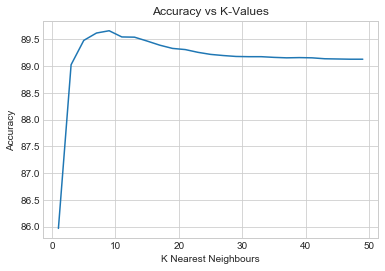

In [29]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [30]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  9
Best Accuracy 89.657094%


In [31]:
x_test = count_vect.transform(x_test)
x_test = normalize(x_test)

In [32]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [33]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.5,0.897975,0.994743,0.943885


True Positive 10597
True Negative 143
False Positive 1204
False Negative 56


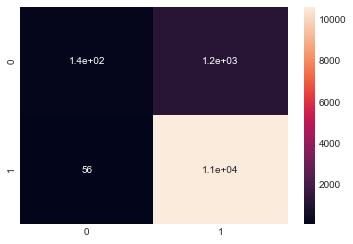

In [34]:
confusion_matrix_plot(y_test,pred)

### BOW - KD- Tree Algorithm

In [41]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'].head(5000) ,knn_data['Score'].head(5000), test_size=0.3, random_state=0)
x_test.head()

329142    seduc breakfast blend coffe drink later day wi...
147832    anni homegrown delux shell real age wisconsin ...
186138    item along laxat tea work well use cleans help...
374131    dont dissappoint machin first flavor youv tri ...
473801    made wish born without tast bud tast sicken sw...
Name: Cleaned_Text, dtype: object

In [42]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = count_vect.transform(x_test)
x_test = normalize(x_test)

In [43]:
x_train = x_train.todense()

In [44]:
knn = KNeighborsClassifier(algorithm='kd_tree')
time_split_cv = TimeSeriesSplit(n_splits = 5)
params = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid = params,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 243.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [45]:
save_data(grid_search.cv_results_,'bow_grid_search_2')

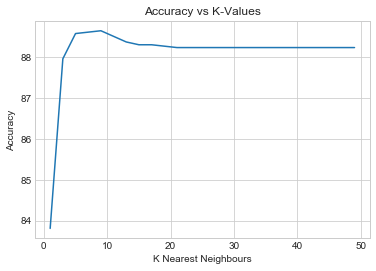

In [46]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [47]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  9
Best Accuracy 88.644940%


In [48]:
x_test = x_test.todense()

In [49]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [50]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.666667,0.891746,0.99247,0.939416


True Positive 1318
True Negative 12
False Positive 160
False Negative 10


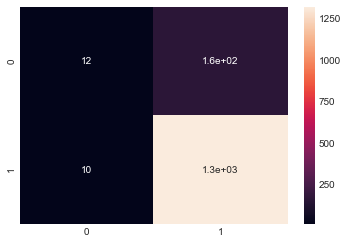

In [51]:
confusion_matrix_plot(y_test,pred)

### KNN - Trigram 

In [52]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'] ,knn_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

In [53]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
x_train = normalize(x_train)

In [54]:
x_test = ngram_vect.transform(x_test)
x_test = normalize(x_test)

### Trigram - Brute Algorithm

In [55]:
knn = KNeighborsClassifier(algorithm='brute')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 29.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [57]:
save_data(grid_search.cv_results_,'trigram_grid_search')

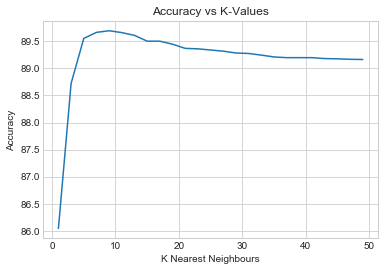

In [58]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [59]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  9
Best Accuracy 89.695671%


In [60]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [61]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.583333,0.899075,0.994274,0.944281


True Positive 10592
True Negative 158
False Positive 1189
False Negative 61


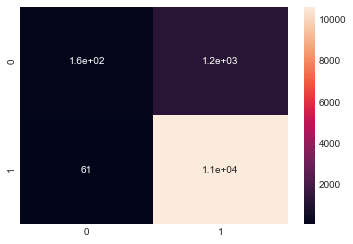

In [62]:
confusion_matrix_plot(y_test,pred)

### Trigram - KD-Tree Algorithm

In [67]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'].head(2000) ,knn_data['Score'].head(2000), test_size=0.3, random_state=0)
x_test.head()

443671    purchas three one two friend noth keep open bo...
9692      local coffe shop use mix great think buy home ...
120425    freshest dri pepper sinc live texa difficult f...
154469    recent bought pack san pellegrino chinotto loc...
269135    one top fav good one dissapoint like habanero ...
Name: Cleaned_Text, dtype: object

In [68]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normalize(x_test)

In [69]:
x_train = x_train.todense()
x_test = x_test.todense()

In [70]:
knn = KNeighborsClassifier(algorithm='kd_tree')
time_split_cv = TimeSeriesSplit(n_splits = 5)
params = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid = params,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 240.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [71]:
save_data(grid_search.cv_results_,'trigram_grid_search_2')

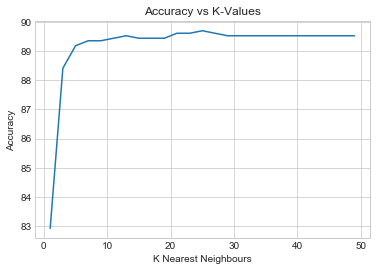

In [72]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [73]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  25
Best Accuracy 89.699571%


In [74]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='kd_tree')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [75]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.166667,0.882943,0.99811,0.937001


True Positive 528
True Negative 1
False Positive 70
False Negative 1


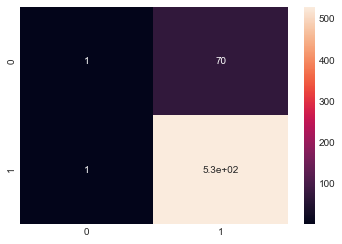

In [76]:
confusion_matrix_plot(y_test,pred)

### KNN - Tf-Idf

In [77]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'],knn_data['Score'], test_size=0.3, random_state=0)
x_test.head()

346013    got excel servic movi arriv promis date qualit...
59348     recepi box produc good muffin need add egg mak...
2009      tast better look first thing said skeptic look...
381644    look gluten free cereal sweet one tast like co...
259086    navita natur certifi organ goji berri wonder s...
Name: Cleaned_Text, dtype: object

In [78]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
x_train = normalize(x_train)

In [79]:
x_test = tf_idf_vect.transform(x_test)
x_test = normalize(x_test)

### Tf-Idf Brute Algorithm

In [80]:
knn = KNeighborsClassifier(algorithm='brute')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 30.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [81]:
save_data(grid_search.cv_results_,'tfidf_grid_search')

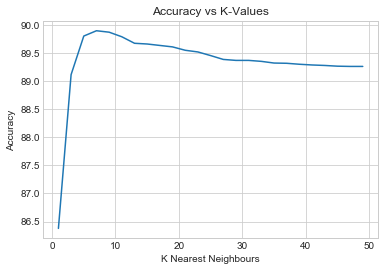

In [82]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [83]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  7
Best Accuracy 89.892842%


In [84]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [85]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.875,0.901207,0.995025,0.945795


True Positive 10600
True Negative 185
False Positive 1162
False Negative 53


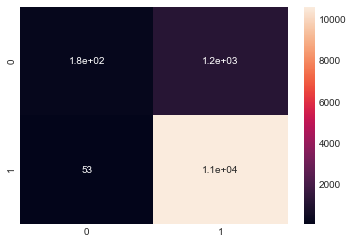

In [86]:
confusion_matrix_plot(y_test,pred)

### Tf-Idf KD Tree Algorithm

In [87]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'].head(2000),knn_data['Score'].head(2000), test_size=0.3, random_state=0)
x_test.head()

443671    purchas three one two friend noth keep open bo...
9692      local coffe shop use mix great think buy home ...
120425    freshest dri pepper sinc live texa difficult f...
154469    recent bought pack san pellegrino chinotto loc...
269135    one top fav good one dissapoint like habanero ...
Name: Cleaned_Text, dtype: object

In [88]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
x_train = normalize(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normalize(x_test)

In [89]:
x_train = x_train.todense()
x_test = x_test.todense()

In [90]:
knn = KNeighborsClassifier(algorithm='kd_tree')
time_split_cv = TimeSeriesSplit(n_splits = 5)
params = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid = params,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 261.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [91]:
save_data(grid_search.cv_results_,'tfidf_grid_search_2')

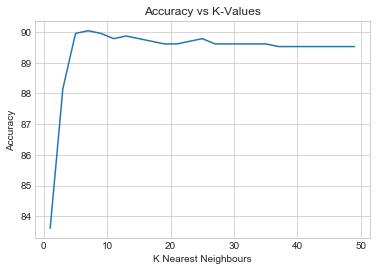

In [92]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [93]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  7
Best Accuracy 90.042918%


In [94]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='kd_tree')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [95]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.5,0.888514,0.994329,0.938448


True Positive 526
True Negative 5
False Positive 66
False Negative 3


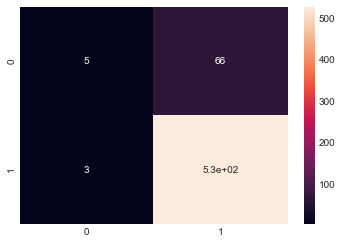

In [96]:
confusion_matrix_plot(y_test,pred)

### KNN - Word2Vec

In [114]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'] ,knn_data['Score'], test_size=0.3, random_state=0)
x_train.head()

420113    sho like serious realli good quit cheesi mix p...
163143    first loos leaf tea ever tri direct said teasp...
355051    youv ever eaten indian food good restaur india...
421880    purchas birthday gift friend hoot hit natur ch...
17807     disappoint qualiti product smell stale tast su...
Name: Cleaned_Text, dtype: object

In [115]:
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [116]:
w2v_model = Word2Vec(list_of_sent,min_count=5,workers=4,size=100)

In [117]:
w2v_words = list(w2v_model.wv.vocab)

In [118]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [119]:
sent_vectors_arr = np.asarray(sent_vectors)

In [120]:
sent_vectors_normalize = normalize(sent_vectors_arr)

In [121]:
x_train, x_test, y_train, y_test = train_test_split(sent_vectors_normalize ,y_train, test_size=0.3, random_state=0)

In [125]:
y_test.shape

(8400,)

### Word2Vec Brute Algorithm

In [126]:
knn = KNeighborsClassifier(algorithm='brute')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [127]:
save_data(grid_search.cv_results_,'w2v_grid_search')

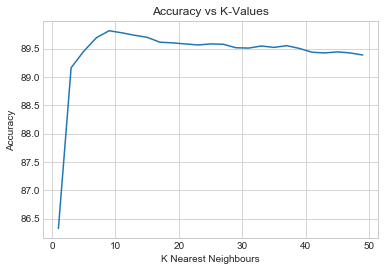

In [128]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [129]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  9
Best Accuracy 89.816289%


In [131]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [132]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,90.059524,0.907351,0.989296,0.946553


True Positive 7394
True Negative 171
False Positive 755
False Negative 80


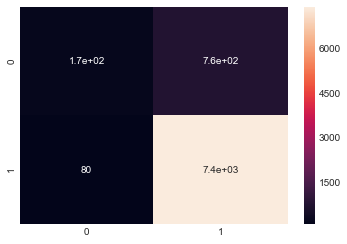

In [133]:
confusion_matrix_plot(y_test,pred)

### Word2Vec - KD-Tree

In [136]:
knn = KNeighborsClassifier(algorithm='kd_tree')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 680.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [137]:
save_data(grid_search.cv_results_,'w2v_grid_search_2')

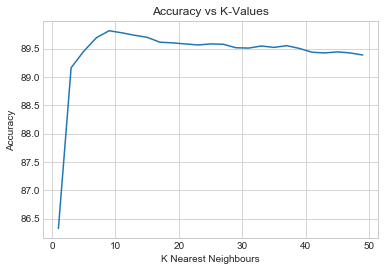

In [138]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [139]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  9
Best Accuracy 89.816289%


In [140]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='kd_tree')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [141]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,90.059524,0.907351,0.989296,0.946553


True Positive 7394
True Negative 171
False Positive 755
False Negative 80


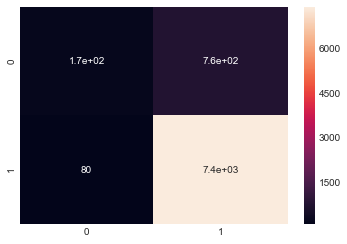

In [142]:
confusion_matrix_plot(y_test,pred)

### Tf-Idf Word2Vec

In [143]:
x_train, x_test, y_train, y_test = train_test_split(knn_data['Cleaned_Text'] ,knn_data['Score'], test_size=0.3, random_state=0)
x_train.head()

420113    sho like serious realli good quit cheesi mix p...
163143    first loos leaf tea ever tri direct said teasp...
355051    youv ever eaten indian food good restaur india...
421880    purchas birthday gift friend hoot hit natur ch...
17807     disappoint qualiti product smell stale tast su...
Name: Cleaned_Text, dtype: object

In [144]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)

In [145]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    if row == (x_train.shape[0]):
        break

In [146]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)

In [147]:
tfidf_sent_vectors_normalize = normalize(tfidf_sent_vectors_arr)

In [148]:
tfidf_sent_vectors_normalize.shape
knn_scores = knn_data['Score'].head(tfidf_sent_vectors_normalize.shape[0])

In [149]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_sent_vectors_normalize ,knn_scores, test_size=0.3, random_state=0)
y_train.shape

(19600,)

### Tfidf Word2Vec - Brute Algorithm

In [150]:
knn = KNeighborsClassifier(algorithm='brute')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [151]:
save_data(grid_search.cv_results_,'tfidf_w2v_grid_search')

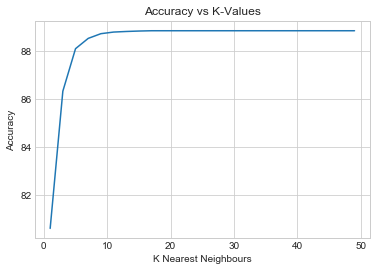

In [152]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [153]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  17
Best Accuracy 88.860992%


In [155]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='brute')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [156]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.261905,0.892619,1.0,0.943263


True Positive 7498
True Negative 0
False Positive 902
False Negative 0


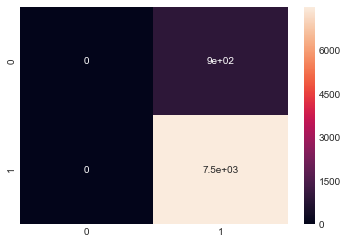

In [157]:
confusion_matrix_plot(y_test,pred)

### Tfidf Word2Vec - KD Tree

In [158]:
knn = KNeighborsClassifier(algorithm='kd_tree')
time_split_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_neighbors':np.arange(1,50,2)}
grid_search = GridSearchCV(knn,param_grid,cv=time_split_cv,verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 190.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [159]:
save_data(grid_search.cv_results_,'tfidf_w2v_grid_search_2')

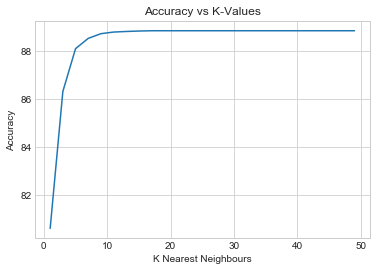

In [160]:
acc_vs_kvalue_plot(grid_search.cv_results_['mean_test_score']*100)

In [161]:
print('Best K-Value ',grid_search.best_params_.get('n_neighbors'))
print('Best Accuracy %f% %'%(grid_search.best_score_*100))

Best K-Value  17
Best Accuracy 88.860992%


In [162]:
knn_optimal = KNeighborsClassifier(n_neighbors = grid_search.best_params_.get('n_neighbors'),algorithm='kd_tree')
knn_optimal.fit(x_train, y_train)
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [163]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.261905,0.892619,1.0,0.943263


True Positive 7498
True Negative 0
False Positive 902
False Negative 0


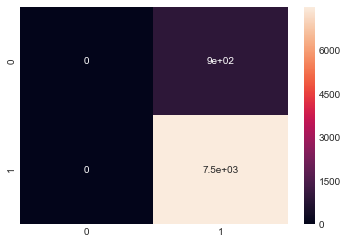

In [164]:
confusion_matrix_plot(y_test,pred)

## Summary

In [194]:
summary_of_scores()

+--------------+-----------+--------+-------------------+
|    Model     | Algorithm | Best K |   Best Accuracy   |
+--------------+-----------+--------+-------------------+
|     BOW      |   Brute   |   9    | 89.65709387055294 |
|     BOW      |  KD-Tree  |   9    | 88.64493996569468 |
|   Trigram    |   Brute   |   9    | 89.69567081011573 |
|   Trigram    |  KD-Tree  |   25   | 89.69957081545064 |
|    Tf-Idf    |   Brute   |   7    | 89.89284183454778 |
|    Tf-Idf    |  KD-Tree  |   7    | 90.04291845493563 |
|     W2V      |   Brute   |   9    |  89.8162890385793 |
|     W2V      |  KD-Tree  |   9    |  89.8162890385793 |
| Tf-Idf - W2v |   Brute   |   17   | 88.86099203919167 |
| Tf-Idf - W2v |  KD-Tree  |   17   | 88.86099203919167 |
+--------------+-----------+--------+-------------------+
